<a href="https://colab.research.google.com/github/manalibhoir22/manali/blob/master/SentiWordNetmain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import pandas as pd
import string
import nltk 
from nltk.corpus import stopwords
from nltk import PorterStemmer
import re
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn import metrics

nltk.download('sentiwordnet')
from nltk.tokenize import word_tokenize
df = pd.read_excel('data.xlsx')
df.drop(df.columns[[0,1,3,4,7,8,9]],axis=1,inplace=True)
df.head()
df.isnull().sum()

[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


asin           0
reviewText    99
overall        0
dtype: int64

In [14]:
# Check for whitespace strings (it's OK if there aren't any!):
blanks = []  # start with an empty list

for i,asin,rv,ov in df.itertuples():  # iterate over the DataFrame
    if type(rv)==str:            # avoid NaN values
        if rv.isspace():         # test 'review' for whitespace
            blanks.append(i)     # add matching index numbers to the list
        
len(blanks)

0

In [15]:
df.dropna(inplace=True)

In [16]:
df['reviewText']=df['reviewText'].apply(str)
df.head()

,asin,reviewText,overall
0,120401325X,They look good and stick good! I just don't li...,4
1,120401325X,These stickers work like the review says they ...,5
2,120401325X,These are awesome and make my phone look so st...,5
3,120401325X,Item arrived in great time and was in perfect ...,4
4,120401325X,"awesome! stays on, and looks great. can be use...",5


In [17]:
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

stop_words = ['in','of','at','a','the','and','is','on','an','they','was','it','i','them','to','these','this']

def decontracted(phrase):
    phrase=re.sub(r"won't","will not",phrase)
    phrase=re.sub(r"can't","can not",phrase)
    phrase=re.sub(r"n\'t"," not",phrase)
    phrase=re.sub(r"\'re"," are",phrase)
    phrase=re.sub(r"\'s"," is",phrase)
    phrase=re.sub(r"\'d"," would",phrase)
    phrase=re.sub(r"\'ll"," will",phrase)    
    phrase=re.sub(r"\'t"," not",phrase)
    phrase=re.sub(r"\'ve"," have",phrase)
    phrase=re.sub(r"\'m"," am",phrase)
    return phrase

In [18]:
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

##STEMMING USING SNOWBALL
snow_stemmer = SnowballStemmer(language='english')

#LEMMATIZATION
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [19]:
def sentiment(n):
    return 1 if n >= 4 else 0
df['sentiment'] = df['overall'].apply(sentiment)
df.head()

,asin,reviewText,overall,sentiment
0,120401325X,They look good and stick good! I just don't li...,4,1
1,120401325X,These stickers work like the review says they ...,5,1
2,120401325X,These are awesome and make my phone look so st...,5,1
3,120401325X,Item arrived in great time and was in perfect ...,4,1
4,120401325X,"awesome! stays on, and looks great. can be use...",5,1


In [20]:
from sklearn.model_selection import train_test_split

X = df['reviewText']  # this time we want to look at the text
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('Training Data Shape:', X_train.shape)
print('Testing Data Shape: ', X_test.shape)

Training Data Shape: (130207,)
Testing Data Shape:  (64133,)


In [21]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag

In [22]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
from nltk import sent_tokenize, word_tokenize, pos_tag
 
lemmatizer = WordNetLemmatizer()
 
def penn_to_wn(tag):
    """
    Convert between the PennTreebank tags to simple Wordnet tags
    """
    if tag.startswith('J'):
        return wn.ADJ
    elif tag.startswith('N'):
        return wn.NOUN
    elif tag.startswith('R'):
        return wn.ADV
    elif tag.startswith('V'):
        return wn.VERB
    return None

def clean_text(text):
    
    text = text.replace("<br />", " ")
    
    return text
 
def swn_polarity(text):
    """
    Return a sentiment polarity: 0 = negative, 1 = positive
    """
 
    sentiment = 0.0
    tokens_count = 0
 
    text = clean_text(text)
 
 
    raw_sentences = sent_tokenize(text)
    for raw_sentence in raw_sentences:
        tagged_sentence = pos_tag(word_tokenize(raw_sentence))
 
        for word, tag in tagged_sentence:
            wn_tag = penn_to_wn(tag)
            if wn_tag not in (wn.NOUN, wn.ADJ, wn.ADV):
                continue
 
            lemma = lemmatizer.lemmatize(word, pos=wn_tag)
            if not lemma:
                continue
 
            synsets = wn.synsets(lemma, pos=wn_tag)
            if not synsets:
                continue
 
            # Take the first sense, the most common
            synset = synsets[0]
            swn_synset = swn.senti_synset(synset.name())
 
            sentiment += swn_synset.pos_score() - swn_synset.neg_score()
            tokens_count += 1
 
    # judgment call ? Default to positive or negative
    if not tokens_count:
        return 0
 
    # sum greater than 0 => positive sentiment
    if sentiment >= 0:
        return 1
 
    # negative sentiment
    return 0

#Since we're shuffling, you'll get diffrent results
print swn_polarity(train_X[0]), train_y[0] # 1 1
print swn_polarity(train_X[1]), train_y[1] # 0 0
print swn_polarity(train_X[2]), train_y[2] # 0 1
print swn_polarity(train_X[3]), train_y[3] # 1 1
print swn_polarity(train_X[4]), train_y[4] # 1 1`

In [23]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
swn_polarity('Hello i am not happy')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


1

In [47]:
y_pred = [swn_polarity(text) for text in X_test]
 
print(metrics.accuracy_score(y_test,y_pred))

0.664010727706485


In [48]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.ocean):
    """
    Create a confusion matrix plot for 'good' and 'bad' rating values 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 20)
    plt.yticks(tick_marks, classes, fontsize = 20)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 40)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 30)
    plt.xlabel('Predicted Label', fontsize = 30)

    return plt

def disp_confusion_matrix(y_pred, model_name):
    """
    Display confusion matrix for selected model with TF-IDF Vectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 10))
    plot = plot_confusion_matrix(cm, classes=['Negative','Positive'], normalize=False, 
                                 title = model_name + " "+ '\nConfusion Matrix')
    plt.show()

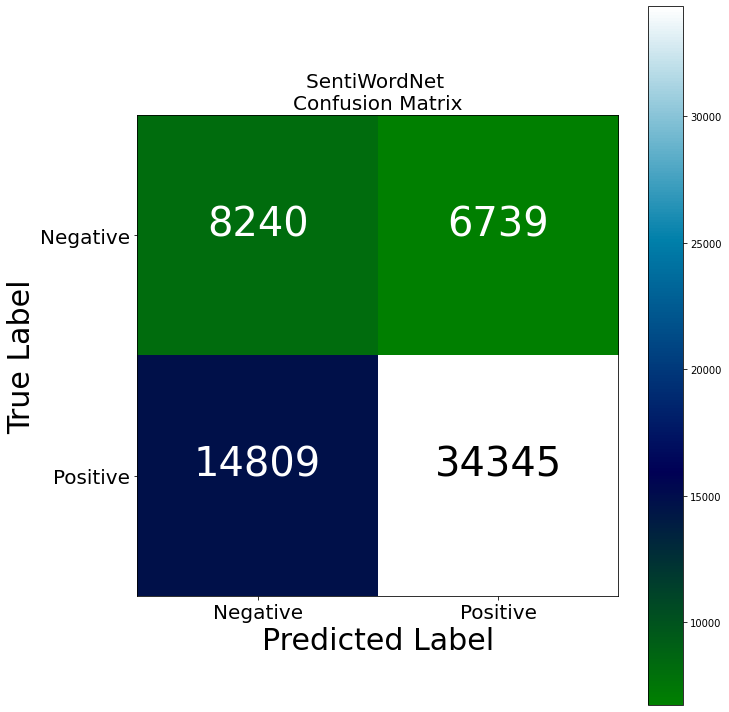

In [49]:
disp_confusion_matrix(y_pred, "SentiWordNet")

In [53]:
import numpy as np
import pandas as pd
import string
import nltk 
from nltk.corpus import stopwords
from nltk import PorterStemmer
import re
from nltk.tokenize import word_tokenize
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer 

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Visualizations
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import matplotlib.colors as colors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer



## Modeling
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from tqdm import tqdm
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
from sklearn import metrics
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
#XGB and TFIDF VECTORIZER:

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from gensim.models import Word2Vec
from sklearn.dummy import DummyClassifier
import numpy as np
import pandas as pd

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [54]:
# Function for converting the "classification report" results to a dataframe
def pandas_classification_report(y_true, y_pred):
    metrics_summary = precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index)

    support = class_report_df.loc['support']
    total = support.sum() 
    avg[-1] = total

    class_report_df['weighted avg'] = avg

    return class_report_df.T

# Function for adding explanatory columns and organizing all dataframe
def comparison_matrix(y_test, y_pred, label):
    df = pandas_classification_report(y_test, y_pred)
    df['class']=['Negative or "0"', 'Positive or "1"', 'average']
    df['accuracy']= metrics.accuracy_score(y_test, y_pred)
    df['model'] = label
    df = df[[ 'model', 'accuracy', 'class', 'precision', 'recall', 'f1-score', 'support']]
    return df

In [55]:
#For loop for using "comparison functions" 

def comparison_table(y_preds, labels):
    
    # empty list for collecting dataframes
    frames_tv = [] 
    
    # list for y_preds
    y_preds_tv = y_preds
    
    # list for labels
    labels_tv = labels  
    
    
    for y_pred, label in zip(y_preds_tv, labels_tv):
        df = comparison_matrix(y_test, y_pred, label)
        frames_tv.append(df)

    # concatenating all dataframes
    global df_tv
    df_tv = pd.concat(frames_tv)
    
    global df_tv2
    df_tv2 = df_tv.set_index([ 'model', 'accuracy', 'class'])

In [56]:
comparison_table(y_preds = [y_pred], 
                labels = ['SentiWordNet'])

In [57]:
df_tv2

precision    recall  f1-score  support
model        accuracy class                                                  
SentiWordNet 0.664011 Negative or "0"   0.357499  0.550103  0.433365  14979.0
                      Positive or "1"   0.835970  0.698722  0.761209  49154.0
                      average           0.724218  0.664011  0.684637  64133.0

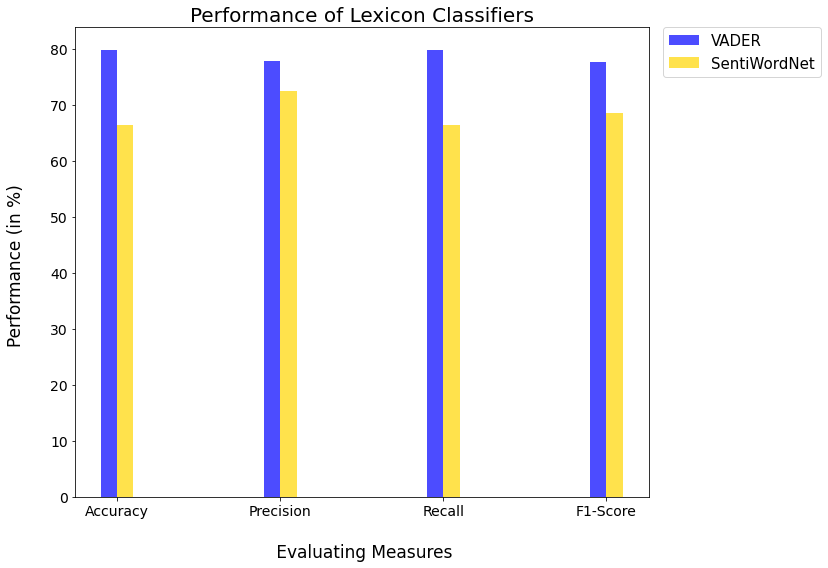

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
n_groups = 4
score_vader = (79.79,77.75,79.79,77.57)
score_sentiwordnet = (66.40,72.42,66.40,68.46)

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.7
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index,score_vader, bar_width,
 alpha=opacity, color='blue',
 error_kw = error_config,
 label='VADER')

z=index + bar_width
rects2 = ax.bar(z, score_sentiwordnet, bar_width,
 alpha=opacity, color='gold',
 error_kw=error_config,
 label='SentiWordNet')




ax.set_xlabel('\n Evaluating Measures',fontsize = 17)
ax.set_ylabel('Performance (in %) \n',fontsize = 17)
ax.set_title('Performance of Lexicon Classifiers',fontsize=20)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Accuracy', 'Precision', 'Recall','F1-Score'),fontsize = 14)
ax.set_yticklabels((0,10,20,30,40,50,60,70,80),fontsize = 14)
ax.legend(bbox_to_anchor=(1.3, 1.0), borderaxespad=0,fontsize=15)
fig.set_size_inches(12,8)
fig.tight_layout()
plt.show()

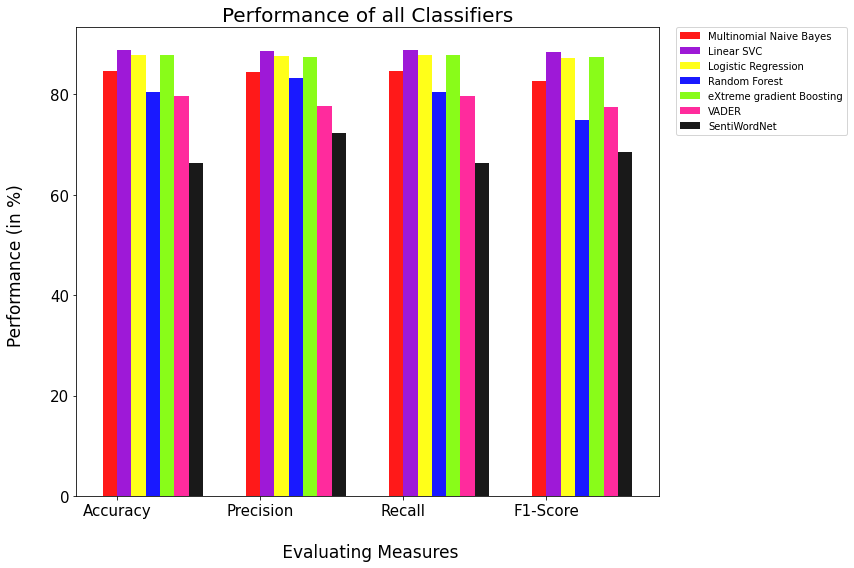

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import namedtuple
n_groups = 4
score_MNB = (84.62,84.43,84.62,82.72)
score_LSVC = (88.92,88.57,88.92,88.53)
score_LR=(87.93,87.59,87.93,87.21)
score_RF=(80.52,83.22,80.51,74.95)
score_XGB=(87.87,87.42,87.87,87.41)
score_vader = (79.79,77.75,79.79,77.57)
score_sentiwordnet = (66.40,72.42,66.40,68.46)

#n1=(score_MNB[0], score_LR[0], score_LSVC[0], score_RF[0],score_XGB[0])
#n2=(score_MNB[1], score_LR[1], score_LSVC[1], score_RF[1],score_XGB[1])
#n3=(score_MNB[2], score_LR[2], score_LSVC[2], score_RF[2],score_XGB[2])
#n4=(score_MNB[3], score_LR[3], score_LSVC[3], score_RF[3],score_XGB[3])

fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.1
opacity = 0.9
error_config = {'ecolor': '0.3'}

rects1 = ax.bar(index,score_MNB, bar_width,
 alpha=opacity, color='red',
 error_kw=error_config,label='Multinomial Naive Bayes')

z=index + bar_width
rects2 = ax.bar(z, score_LSVC, bar_width,
 alpha=opacity, color='darkviolet',
 error_kw=error_config,
 label='Linear SVC')

z=z+ bar_width
rects3 = ax.bar(z, score_LR, bar_width,
 alpha=opacity, color='yellow',
 error_kw=error_config,
 label='Logistic Regression')

z=z+ bar_width
rects4 = ax.bar(z, score_RF, bar_width,
 alpha=opacity, color='blue',
 error_kw=error_config,label='Random Forest')

z=z+ bar_width
rects5 = ax.bar(z, score_XGB, bar_width,
 alpha=opacity, color='lawngreen',
 error_kw=error_config,
 label='eXtreme gradient Boosting')

z=z + bar_width
rects6 = ax.bar(z, score_vader, bar_width,
 alpha=opacity, color='deeppink',
 error_kw=error_config,
 label='VADER')

z=z + bar_width
rects7 = ax.bar(z, score_sentiwordnet, bar_width,
 alpha=opacity, color='black',
 error_kw=error_config,
 label='SentiWordNet')

ax.set_xlabel('\n Evaluating Measures',fontsize = 17)
ax.set_ylabel('Performance (in %) \n',fontsize = 17)
ax.set_title('Performance of all Classifiers',fontsize=20)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(('Accuracy', 'Precision', 'Recall','F1-Score'),fontsize = 15)
ax.set_yticklabels((0,20,40,60,80),fontsize = 15)
ax.legend(bbox_to_anchor=(1.03, 1.0), borderaxespad=0)
fig.set_size_inches(12,8)
fig.tight_layout()
plt.show()

